In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from PIL import Image

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import time

## Wstęp

W poniższym raporcie model głębokiej sieci neuronowej zostanie wykorzystany do interpretowania liter języka migowego.

Zbiór składa się z 87000 zdjęć podzielonych na 29 klas - liter od A do Z oraz znaków *del, nothing, space*. Oprócz tego dostępne są również zdjęcia "testowe" - po jednym dla każdej klasy.

### Przykładowe zdjęcie

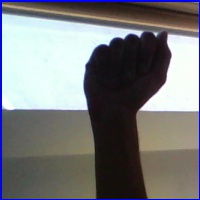

In [2]:
Image.open('./asl_alphabet_test/asl_alphabet_test/A_test.jpg')

## Przygotowanie danych

Transormacje testowe oraz treningowe przygotowywane są osobno, ponieważ wymagają one trochę innego podejścia.

Transformacje testowe zawierają podstawowe przygotowanie danych - przekonwertowanie na tensor (ToTensor) oraz normalizację (Normalize). 

Normalizacja pozwala na stabilizację gradientu obliczanego w procesie uczenia się sieci, co przyspiesza proces samego uczenia oraz poprawia jakość modelu. Polega ona po prostu na odjęciu od kazdej wartości średniej i podzieleniu przed ochylenie standardowe (dla danego koloru). 
Pomimo faktu, że model budowany jest od poczatku, użyte zostały wartości wcześniej wyliczone dla milionów obrazów przez ImageNet, a normalizacja według nich jest popularną praktyką.

Dla danych treningowych dodane zostały dwie dodatkowe transformacje: RandomHorizontalFlip, która odwraca obraz z domyślnym prawdopodobieństwem p=0.5 oraz RandomRotation(20), która obraca kazde zdjecie losowo o liczbe stopni z zakresu (-20,20).

Technika ta pozwala na zwielokrotnienie zbioru danych, ponieważ powyższe modyfikacje aplikowane są niezależnie od siebie w każdej iteracji uczenia algorytmu, więc za każdym razem algorytm dostaje trochę inne dane.

In [3]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Wczytanie danych wraz ze zdefiniowanymi wcześniej transformacjami.
Dane wczytywane są podwójnie, ponieważ pozwala to wykonać różne transformacje, a następnie wybrać zbiór treningowy i testowy.

In [4]:
train_data = datasets.ImageFolder('./asl_alphabet_train/asl_alphabet_train',transform=train_transform)
test_data = datasets.ImageFolder('./asl_alphabet_train/asl_alphabet_train',transform=test_transform)

Jako, że obrazy są podawane do sieci w seriach (eng. batch), wykorzystanie SubsetRandomSamplera pozwala na dobór obrazów do każdej serii w taki sposób, aby poszczególne klasy występowały w nich w miarę równomiernie.

In [5]:
class_names = train_data.classes

num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))

np.random.seed(1)
np.random.shuffle(indices)
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx) 
test_sampler = SubsetRandomSampler(test_idx)

In [6]:
batch_size = 100
workers = 5

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=train_sampler, num_workers=workers)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, sampler=test_sampler, num_workers=workers)

## Wyświetlanie obrazów

Class: ['W', 'Z', 'C', 'G', 'del', 'O', 'J', 'O', 'K', 'T']


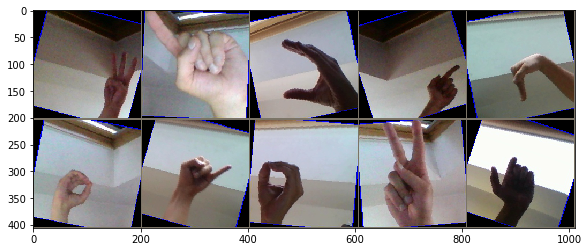

In [9]:
# pobranie obrazów/klas z jednej serii (wielkość serii chwilowo ustawiona na 10)
for images,labels in train_loader: 
    break

# klasa jest zakodowana cyfrą, dlatego pobrany zostaje jej odpowiednik z listy nazw
print('Class:', [class_names[i] for i in labels])

im = make_grid(images, nrow=5)
# denormalizacja obrazow, żeby widok był przyjemny dla ludzkiego oka
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,4))
# imshow wymaga podania wymiarów w innej kolejności
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

## Architektura sieci i parametry

Zbudowana sieć składa się z dwóch warstw konwolucyjnych z następującymi po nich warstwami łączącymi (eng. pooling layer). 
Poszczególne neurony w warstwach konwolucyjnych są połączone jedynie lokalnie, a warstwy łączący pozwalają na znaczną redukcję ilości parametrów, co wiąże się z zarówno skróceniem czasu uczenia, jak i poprawą jakości modelu, ponieważ ograniczenie liczby parametrów pozwala uniknąć przeuczenia się sieci.

Następnie sieć składa się z trzech warstw w pełni połączonych (eng. fully connected layers).

Opis przykładowych parametrów:

**nn.Conv2d(3, 6, 3, 1)**

    3 - liczba kanałów wejściowych, wynika bezpośrednio z liczby kolorów (eng. channels)

    6 - liczba wyjść, wybór arbitralny

    3 - rozmiar filtra (jednoczesnie warunkuje utratę informacji na brzegach macierzy)

    1 - krok (co który element "nakładamy filtr")
    
**F.max_pool2d(X, 2, 2)**

    2 - rozmiar filtra (2x2)
    
    2 - krok
    
**nn.Linear(48 * 48 * 12, 200)**
    
    48x48x12 - wejście, gdzie "48x48" to szerokość x wysokość po przekształceniach przez warstwy konwolucyjne i łączące, a 12 to ilość wyjść z ostatniej warstwy łączącej
    
    200 - liczba wyjść

Liczba wyjść z ostatniej warstwy musi być równa ilości klas - w przypadku wybranych danych jest to 29.

Funkcja aktywacji wykorzystywana na każdym etapie to **rectified linear unit (ReLU)**.

Na wyjścia sieci aplikowana jest funkcja **softmax** konwertująca logity na prawdopodobieństwa.

In [7]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 12, 3, 1)
        #(((200-2)/2) - 2)/2 = 48.5; zaokrąglone w dół
        self.fc1 = nn.Linear(48*48*12, 1000)
        self.fc2 = nn.Linear(1000, 80)
        self.fc3 = nn.Linear(80, 29)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 48*48*12)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [8]:
CNNmodel = ConvolutionalNetwork()

### Podsumowanie parametrów modelu

In [9]:
CNNmodel.parameters

<bound method Module.parameters of ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=27648, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=29, bias=True)
)>

# Uczenie

W trakcie uczenia zbierane są statystki dotyczące działania algorytmu. 

Po każdej epoce sieć jest testowana z wykorzystaniem opcji **torch.no_grad**, która nie pozwala na dostosowywanie parametrów. Dzięki temu będzie można łatwo stwierdzić, czy sieć nie uległa w pewnym momencie przeuczeniu i dostosować ilość epok.

In [10]:
def train_model(CNNmodel, criterion, optimizer, epochs):
    start_time = time.time()

    train_losses = []
    test_losses = []
    train_correct = []
    test_correct = []

    for i in range(epochs):
        trn_corr = 0
        tst_corr = 0

        for b,(X_train,y_train) in enumerate(train_loader):

            b+=1
            
            # predykcja
            y_pred = CNNmodel(X_train)
            # strata
            loss = criterion(y_pred, y_train)
            S
            # przewidywana klasa
            predicted = torch.max(y_pred,1)[1]
            # liczba poprawnych predykcji
            batch_corr = (predicted == y_train).sum()
            trn_corr += batch_corr

            # zerowanie gradientu
            optimizer.zero_grad()
            # propagacja wsteczna
            loss.backward()
            # uaktualnienie parametrów
            optimizer.step()

            if b%100 == 0:
                print(f'Epoka: {i}, seria: {b}, strata: {loss}, dokładność: {trn_corr.item()/b:7.3f}%')

        train_losses.append(loss)
        train_correct.append(trn_corr)

        # testowanie po każdej iteracji
        with torch.no_grad():
            for b, (X_test, y_test) in enumerate(test_loader):

                y_val = CNNmodel(X_test)

                predicted = torch.max(y_val,1)[1]
                tst_corr += (predicted == y_test).sum()

        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)

    total_time = (time.time() - start_time)/60
    
    print(f'Czas uczenia: {total_time} minut.')
    
    return CNNmodel, train_losses, test_losses, train_correct, test_correct

## Uczenie (20 epok,  learning rate=0.001)

In [11]:
criterion = nn.CrossEntropyLoss()

CNNmodel1 = ConvolutionalNetwork()
optimizer1 = torch.optim.Adam(CNNmodel1.parameters(), lr=0.001)

In [12]:
CNNmodel1,train_losses1, test_losses1, train_correct1, test_correct1 = train_model(CNNmodel1, criterion, optimizer1, 20)

Epoka: 0, seria: 100, strata: 2.8533074855804443, dokładność:   6.980%
Epoka: 0, seria: 200, strata: 2.235128879547119, dokładność:  14.060%
Epoka: 0, seria: 300, strata: 2.022268772125244, dokładność:  19.210%
Epoka: 0, seria: 400, strata: 1.7269363403320312, dokładność:  23.505%
Epoka: 0, seria: 500, strata: 1.5261234045028687, dokładność:  27.382%
Epoka: 0, seria: 600, strata: 1.2474361658096313, dokładność:  31.177%
Epoka: 1, seria: 100, strata: 1.176596760749817, dokładność:  60.110%
Epoka: 1, seria: 200, strata: 0.9873506426811218, dokładność:  62.420%
Epoka: 1, seria: 300, strata: 0.815188467502594, dokładność:  64.553%
Epoka: 1, seria: 400, strata: 0.6843301653862, dokładność:  66.368%
Epoka: 1, seria: 500, strata: 0.790938138961792, dokładność:  67.654%
Epoka: 1, seria: 600, strata: 0.6092721223831177, dokładność:  68.798%
Epoka: 2, seria: 100, strata: 0.5844290256500244, dokładność:  80.140%
Epoka: 2, seria: 200, strata: 0.6495596170425415, dokładność:  80.770%
Epoka: 2, seri

Epoka: 19, seria: 100, strata: 0.05735186114907265, dokładność:  96.960%
Epoka: 19, seria: 200, strata: 0.041532158851623535, dokładność:  97.370%
Epoka: 19, seria: 300, strata: 0.06778230518102646, dokładność:  97.427%
Epoka: 19, seria: 400, strata: 0.06503656506538391, dokładność:  97.478%
Epoka: 19, seria: 500, strata: 0.025023939087986946, dokładność:  97.578%
Epoka: 19, seria: 600, strata: 0.05875528231263161, dokładność:  97.623%
Czas uczenia: 109.16904499530793 minut.


In [13]:
torch.save(CNNmodel1.state_dict(), 'model1.pt')
#CNNmodel1.load_state_dict(torch.load('model1.pt'))

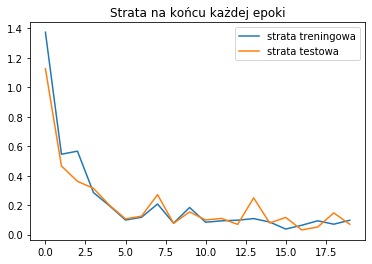

In [14]:
plt.plot(train_losses1, label='strata treningowa')
plt.plot(test_losses1, label='strata testowa')
plt.title('Strata na końcu każdej epoki')
plt.legend()

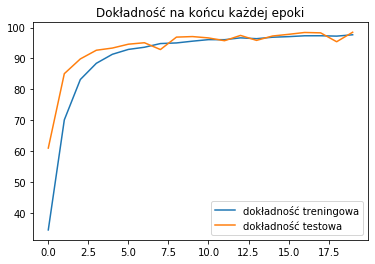

In [15]:
plt.plot([x/(len(train_idx)/100) for x in np.array(train_correct1)], label='dokładność treningowa')
plt.plot([x/(len(test_idx)/100) for x in np.array(test_correct1)], label='dokładność testowa')
plt.title('Dokładność na końcu każdej epoki')
plt.legend()

### Dokładność na danych testowych:

In [16]:
np.array(test_correct1[-1])/len(test_idx) * 100

98.49425287356321

Jest to zdecydowanie najlepszy wynik, jaki udało się nam osiągnąć.

## Uczenie (6 epok,  learning rate=0.01)

In [20]:
criterion = nn.CrossEntropyLoss()

CNNmodel2 = ConvolutionalNetwork()
optimizer2 = torch.optim.Adam(CNNmodel2.parameters(), lr=0.01)

In [21]:
CNNmodel2, train_losses2, test_losses2, train_correct2, test_correct2 = train_model(CNNmodel2, criterion, optimizer2, 6)

Epoka: 0, seria: 100, strata: 3.3754634857177734, dokładność:   3.680%
Epoka: 0, seria: 200, strata: 3.362802505493164, dokładność:   3.565%
Epoka: 0, seria: 300, strata: 3.3719701766967773, dokładność:   3.580%
Epoka: 0, seria: 400, strata: 3.3721706867218018, dokładność:   3.502%
Epoka: 0, seria: 500, strata: 3.3642425537109375, dokładność:   3.482%
Epoka: 0, seria: 600, strata: 3.369100570678711, dokładność:   3.480%
Epoka: 1, seria: 100, strata: 3.367826461791992, dokładność:   3.330%
Epoka: 1, seria: 200, strata: 3.3678455352783203, dokładność:   3.425%
Epoka: 1, seria: 300, strata: 3.366746425628662, dokładność:   3.427%
Epoka: 1, seria: 400, strata: 3.371551275253296, dokładność:   3.345%
Epoka: 1, seria: 500, strata: 3.3715884685516357, dokładność:   3.334%
Epoka: 1, seria: 600, strata: 3.3739774227142334, dokładność:   3.303%
Epoka: 2, seria: 100, strata: 3.3761954307556152, dokładność:   3.340%
Epoka: 2, seria: 200, strata: 3.369856357574463, dokładność:   3.255%
Epoka: 2, se

In [22]:
torch.save(CNNmodel2.state_dict(), 'model2.pt')

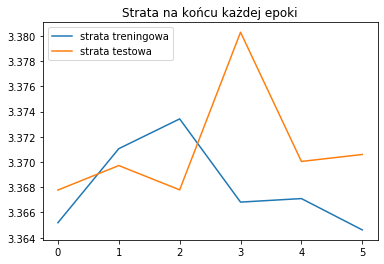

In [23]:
plt.plot(train_losses2, label='strata treningowa')
plt.plot(test_losses2, label='strata testowa')
plt.title('Strata na końcu każdej epoki')
plt.legend()

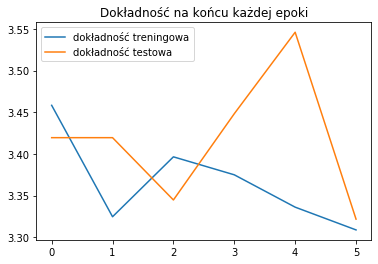

In [24]:
plt.plot([x/(len(train_idx)/100) for x in np.array(train_correct2)], label='dokładność treningowa')
plt.plot([x/(len(test_idx)/100) for x in np.array(test_correct2)], label='dokładność testowa')
plt.title('Dokładność na końcu każdej epoki')
plt.legend()

### Dokładność:

In [47]:
np.array(test_correct2[-1])/len(test_idx) * 100

3.32183908045977

Learning rate na poziomie 0.01 okazał się być zdecydowanie za duży.

## Uczenie (6 epok,  learning rate=0.005)

In [26]:
criterion = nn.CrossEntropyLoss()

CNNmodel3 = ConvolutionalNetwork()
optimizer3 = torch.optim.Adam(CNNmodel3.parameters(), lr=0.005)

In [27]:
CNNmodel3, train_losses3, test_losses3, train_correct3, test_correct3 = train_model(CNNmodel3, criterion, optimizer3, 6)

Epoka: 0, seria: 100, strata: 2.5911569595336914, dokładność:   5.710%
Epoka: 0, seria: 200, strata: 2.1504266262054443, dokładność:  12.340%
Epoka: 0, seria: 300, strata: 1.6142857074737549, dokładność:  18.387%
Epoka: 0, seria: 400, strata: 1.379347324371338, dokładność:  23.840%
Epoka: 0, seria: 500, strata: 1.1829698085784912, dokładność:  28.784%
Epoka: 0, seria: 600, strata: 1.2303208112716675, dokładność:  33.095%
Epoka: 1, seria: 100, strata: 0.7481870055198669, dokładność:  65.910%
Epoka: 1, seria: 200, strata: 0.8369857668876648, dokładność:  67.005%
Epoka: 1, seria: 300, strata: 0.6457359194755554, dokładność:  68.660%
Epoka: 1, seria: 400, strata: 0.6043732166290283, dokładność:  69.845%
Epoka: 1, seria: 500, strata: 0.7621216773986816, dokładność:  70.664%
Epoka: 1, seria: 600, strata: 0.46827396750450134, dokładność:  71.585%
Epoka: 2, seria: 100, strata: 0.4222491979598999, dokładność:  78.130%
Epoka: 2, seria: 200, strata: 0.5588657855987549, dokładność:  78.285%
Epoka:

In [28]:
torch.save(CNNmodel3.state_dict(), 'model3.pt')

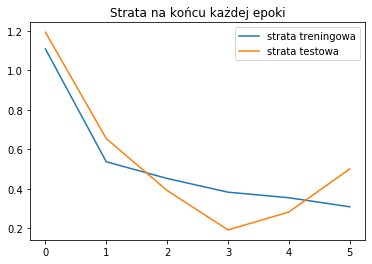

In [29]:
plt.plot(train_losses3, label='strata treningowa')
plt.plot(test_losses3, label='strata testowa')
plt.title('Strata na końcu każdej epoki')
plt.legend()

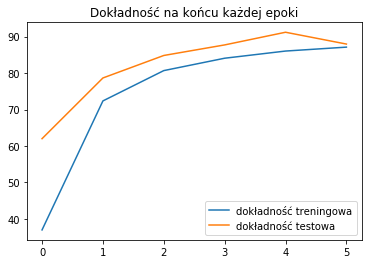

In [30]:
plt.plot([x/(len(train_idx)/100) for x in np.array(train_correct3)], label='dokładność treningowa')
plt.plot([x/(len(test_idx)/100) for x in np.array(test_correct3)], label='dokładność testowa')
plt.title('Dokładność na końcu każdej epoki')
plt.legend()

### Dokładność:

In [49]:
np.array(test_correct3[-1])/len(test_idx) * 100

87.95977011494253

 # Wykorzystanie pre-trenowanej sieci mobilenet_v2

In [31]:
# Pobranie modelu
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True, force_reload=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /home/mat/.cache/torch/hub/v0.6.0.zip


In [32]:
# Zmiana transformacji - model wymaga zdjęć o innym rozmiarze
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## Powtórzenie przygotowania

In [33]:
train_data = datasets.ImageFolder('./asl_alphabet_train/asl_alphabet_train',transform=train_transform)
test_data = datasets.ImageFolder('./asl_alphabet_train/asl_alphabet_train',transform=test_transform)

class_names = train_data.classes

num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))

np.random.seed(1)
np.random.shuffle(indices)
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx) 
test_sampler = SubsetRandomSampler(test_idx)

batch_size = 100
workers = 5

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=train_sampler, num_workers=workers)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, sampler=test_sampler, num_workers=workers)

In [34]:
print(model.classifier)
model.classifier[1] = nn.Linear(1280,29,True)
print(model.classifier)

# "zamrożenie" parametrów sieci
for param in model.parameters():
    param.requires_grad = False

# "odmrożenie" częsci klasyfikującej
for param in model.classifier.parameters():
    param.requires_grad = True
    
optimizer4 = torch.optim.Adam(model.classifier.parameters(), lr=0.01)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=29, bias=True)
)


In [35]:
model, train_losses4, test_losses4, train_correct4, test_correct4 = train_model(model, criterion, optimizer4, 5)

Epoka: 0, seria: 100, strata: 0.8659888505935669, dokładność:  52.770%
Epoka: 0, seria: 200, strata: 0.7568396925926208, dokładność:  63.345%
Epoka: 0, seria: 300, strata: 0.8179596066474915, dokładność:  67.213%
Epoka: 0, seria: 400, strata: 0.7813628315925598, dokładność:  69.772%
Epoka: 0, seria: 500, strata: 0.6937534809112549, dokładność:  71.294%
Epoka: 0, seria: 600, strata: 0.9351621270179749, dokładność:  72.293%
Epoka: 1, seria: 100, strata: 0.5045269727706909, dokładność:  79.600%
Epoka: 1, seria: 200, strata: 0.5744487643241882, dokładność:  79.175%
Epoka: 1, seria: 300, strata: 0.966454029083252, dokładność:  78.837%
Epoka: 1, seria: 400, strata: 0.7451675534248352, dokładność:  79.073%
Epoka: 1, seria: 500, strata: 0.6016742587089539, dokładność:  79.342%
Epoka: 1, seria: 600, strata: 0.7689083218574524, dokładność:  79.470%
Epoka: 2, seria: 100, strata: 1.1978203058242798, dokładność:  80.520%
Epoka: 2, seria: 200, strata: 0.6894109845161438, dokładność:  80.780%
Epoka: 

In [36]:
torch.save(model.state_dict(), 'model4.pt')

### Dokładność:

In [51]:
np.array(test_correct4[-1])/len(test_idx)*100

79.44252873563218

Pomimo trenowania samej częsci klasyfikacyjnej sieci sieci mobilenet_v2, czas uczenia wzrósł znacząco w porównaniu z siecią testowana wczesniej. Wynika to oczywiście z rozmiaru sieci.

# Przewidywanie klasy dla pojedyńczego zdjęcia

Wczytanie najlepszego z wytrenowanych modeli

In [7]:
model = ConvolutionalNetwork()
model.load_state_dict(torch.load('model1.pt'))

<All keys matched successfully>

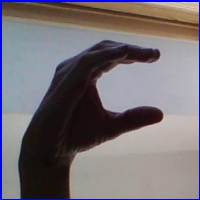

In [33]:
#Wczytanie przykładowego (nowego) zdjęcia litery C
image = Image.open('./asl_alphabet_test/asl_alphabet_test/C_test.jpg')
image

Sieć wymaga dodania do tensora jednego wymiaru, ze względu na fakt że uczenie odbywa się w seriach.

In [24]:
image = test_transform(image)
print(image.shape)
image = image.unsqueeze(0)
print(image.shape)

torch.Size([3, 200, 200])
torch.Size([1, 3, 200, 200])


In [25]:
with torch.no_grad():
    output = model(image)
pos = output[0].argmax()
class_names = train_data.classes
class_names[pos]

'C'

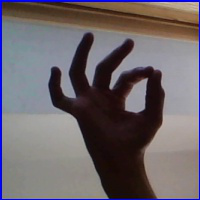

In [32]:
#Wczytanie przykładowego (nowego) zdjęcia litery F
image = Image.open('./asl_alphabet_test/asl_alphabet_test/F_test.jpg')
image

In [29]:
image = test_transform(image)
image = image.unsqueeze(0)
with torch.no_grad():
    output = model(image)
pos = output[0].argmax()
class_names[pos]

'F'

# Źródła

https://davidstutz.de/wordpress/wp-content/uploads/2014/07/seminar.pdf

https://indico.cern.ch/event/766995/contributions/3295783/attachments/1802769/2940979/Daniel_Campora_-_A_practical_approach_to_Convolutional_Neural_Networks_slides.pdf

https://pytorch.org/tutorials/

https://pytorch.org/hub/pytorch_vision_mobilenet_v2/

https://en.wikipedia.org/wiki/Convolutional_neural_network

Zbiór danych: https://www.kaggle.com/grassknoted/asl-alphabet